# Wise-Analytics Data Science Internship Assignment Part 2

### Dataset Overview
The dataset consists of multiple files providing sales data and additional influencing factors:
1. train.csv - Historical sales data.
2. test.csv - The test set for which sales need to be predicted.
3. stores.csv - Metadata about store locations and clusters.
4. oil.csv - Daily oil prices (affecting Ecuador's economy).
5. holidays_events.csv - Information about holidays and special events.

#### Task
Forecast daily sales for each product family at each store for the next 15 days after the last training.

### Data Loading and Inspection

In [60]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import datetime as dt

import sys 
import warnings
if not sys.warnoptions: 
    warnings.simplefilter('ignore')

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)

import os
os.chdir(r'D:\OneDrive\Documents\Course\Imarticus Learning\W Beyond\W Beyond\store_forecasting_data (1) (1)\store_forecasting_data')

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [61]:
train = pd.read_csv('processed_train.csv', low_memory=True)
train.head()

,id,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred,date,day,week,month,year,day_of_week,is_holiday,is_weekend,is_gov_payday,earthquake_impact,is_promotion,sales_ma_7,sales_std_7,sales_ma_30,sales_std_30,sales_lag_1,sales_lag_7,sales_lag_30,avg_store_sales
0,0,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013-01-01,1,1,1,2013,1,True,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.651925
1,1,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013-01-01,1,1,1,2013,1,True,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.651925
2,2,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013-01-01,1,1,1,2013,1,True,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.651925
3,3,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013-01-01,1,1,1,2013,1,True,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.651925
4,4,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013-01-01,1,1,1,2013,1,True,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.651925


### Naive Forecasting

In [62]:
# Baseline Model - Naïve Forecasting
train['naive_forecast'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1)
train['naive_forecast'] = train['naive_forecast'].bfill()
train.head()

,id,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred,date,day,week,month,year,day_of_week,is_holiday,is_weekend,is_gov_payday,earthquake_impact,is_promotion,sales_ma_7,sales_std_7,sales_ma_30,sales_std_30,sales_lag_1,sales_lag_7,sales_lag_30,avg_store_sales,naive_forecast
0,0,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013-01-01,1,1,1,2013,1,True,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.651925,0.0
1,1,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013-01-01,1,1,1,2013,1,True,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.651925,0.0
2,2,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013-01-01,1,1,1,2013,1,True,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.651925,0.0
3,3,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013-01-01,1,1,1,2013,1,True,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.651925,0.0
4,4,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False,2013-01-01,1,1,1,2013,1,True,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.651925,0.0


In [63]:
# Calculate 7-day rolling mean (moving average)
train['rolling_mean_7'] = train['sales'].rolling(window=7).mean()

# Calculate 7-day rolling standard deviation
train['rolling_std_7'] = train['sales'].rolling(window=7).std()

# Fill NaN values with 0
train['rolling_mean_7'] = train['rolling_mean_7'].fillna(0)

# Or use backward filling
train['rolling_mean_7'] = train['rolling_mean_7'].bfill()

### Model Building

In [64]:

# Prepare training data
features = ['day', 'week', 'month', 'year', 'day_of_week', 'is_holiday', 'is_weekend', 
            'is_gov_payday', 'earthquake_impact', 'sales_lag_7', 'sales_lag_30', 'rolling_mean_7', 'rolling_std_7',
            'avg_store_sales'] 
X = train[features].dropna()
y = train.loc[X.index, 'sales']

X.head()

,day,week,month,year,day_of_week,is_holiday,is_weekend,is_gov_payday,earthquake_impact,sales_lag_7,sales_lag_30,rolling_mean_7,rolling_std_7,avg_store_sales
6,1,1,1,2013,1,True,0,0,0,0.0,0.0,0.0,0.0,254.651925
7,1,1,1,2013,1,True,0,0,0,0.0,0.0,0.0,0.0,254.651925
8,1,1,1,2013,1,True,0,0,0,0.0,0.0,0.0,0.0,254.651925
9,1,1,1,2013,1,True,0,0,0,0.0,0.0,0.0,0.0,254.651925
10,1,1,1,2013,1,True,0,0,0,0.0,0.0,0.0,0.0,254.651925


In [65]:
y.head()

6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
Name: sales, dtype: float64

In [66]:
#split the data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.15, random_state=100)
X_train.shape, X_test.shape

((2596190, 14), (458152, 14))

#### ARIMA

In [67]:
# Train ARIMA Model
arima_model = ARIMA(y_train, order=(2,1,0))
arima_model_fit = arima_model.fit(low_memory=True)
arima_preds = arima_model_fit.forecast(steps=len(y_test))

#### Random Forest Regressor

In [68]:
rf_model = RandomForestRegressor(
    n_estimators=50,  # Less trees
    max_depth=10,  # Less depth
        random_state=42
)

X_sample, y_sample = X_train.sample(50000, random_state=42), y_train.loc[X_train.sample(50000, random_state=42).index]
rf_model.fit(X_sample, y_sample)
rf_preds = rf_model.predict(X_test)

In [69]:
rf_model.fit(X_sample, y_sample)

RandomForestRegressor(max_depth=10, n_estimators=50, random_state=42)

In [70]:
rf_model.predict(X_sample)

array([  62.50605768,  128.15647984,  219.03884467, ..., 1032.50321855,
         22.07058958,   38.86126331])

#### XGBoost

In [71]:
# Train XGBoost Model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

In [72]:
#function to tabulate performance metrics of each model
score_card= pd.DataFrame(columns=['Model','R2 Score', 'Root Mean Square Error (RMSE)','Mean Absolute Percentage Error (MAPE)'])

def update_score_card (model_name, y_true, y_pred):
    global score_card
    score_card= score_card._append({'Model': model_name,
                                   'R2 Score': r2_score(y_true,y_pred),
                                   'Root Mean Square Error (RMSE)': np.sqrt(mean_squared_error(y_true,y_pred)),
                                   'Mean Absolute Percentage Error (MAPE)': mean_absolute_percentage_error(y_true, y_pred)}, ignore_index=True)
    return (score_card)

In [73]:
update_score_card("ARIMA", y_test, arima_preds)

,Model,R2 Score,Root Mean Square Error (RMSE),Mean Absolute Percentage Error (MAPE)
0,ARIMA,-2.550585,2099.175199,3.010674e+18


In [74]:
update_score_card("Random Forest Regressor", y_test, rf_preds)

,Model,R2 Score,Root Mean Square Error (RMSE),Mean Absolute Percentage Error (MAPE)
0,ARIMA,-2.550585,2099.175199,3.010674e+18
1,Random Forest Regressor,0.658421,651.094873,1.636273e+17


In [75]:
update_score_card("XGBoost", y_test, xgb_preds)

,Model,R2 Score,Root Mean Square Error (RMSE),Mean Absolute Percentage Error (MAPE)
0,ARIMA,-2.550585,2099.175199,3.010674e+18
1,Random Forest Regressor,0.658421,651.094873,1.636273e+17
2,XGBoost,0.737822,570.422436,1.763444e+17


In [76]:
update_score_card("Naive Forecast", train['sales'], train['naive_forecast'])

,Model,R2 Score,Root Mean Square Error (RMSE),Mean Absolute Percentage Error (MAPE)
0,ARIMA,-2.550585,2099.175199,3.010674e+18
1,Random Forest Regressor,0.658421,651.094873,1.636273e+17
2,XGBoost,0.737822,570.422436,1.763444e+17
3,Naive Forecast,0.842456,439.501165,7.912285e+15


#### LSTM

In [77]:
#LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Convert data to numeric types (assuming X_train contains object/string columns)
X_train_numeric = X_sample.select_dtypes(include=['float64', 'int64'])

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test.select_dtypes(include=['float64', 'int64']))

# Reshape data for
# For time series forecasting without explicit time steps, we can use a lookback window
n_features = X_train_scaled.shape[1]
n_steps = 1  # Using 1 time step initially for simplicity

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], n_steps, n_features))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], n_steps, n_features))

# LSTM model building
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)),
    LSTM(50, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_sample, epochs=50, batch_size=32, verbose=0)

# Predictions
lstm_predictions = lstm_model.predict(X_test_lstm).flatten()

14318/14318 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step


In [78]:
result_table=update_score_card("LSTM", y_test, lstm_predictions)
result_table

,Model,R2 Score,Root Mean Square Error (RMSE),Mean Absolute Percentage Error (MAPE)
0,ARIMA,-2.550585,2099.175199,3.010674e+18
1,Random Forest Regressor,0.658421,651.094873,1.636273e+17
2,XGBoost,0.737822,570.422436,1.763444e+17
3,Naive Forecast,0.842456,439.501165,7.912285e+15
4,LSTM,0.674795,635.297401,2.131981e+17


### Visualization

#### Actual vs Predicted Sales

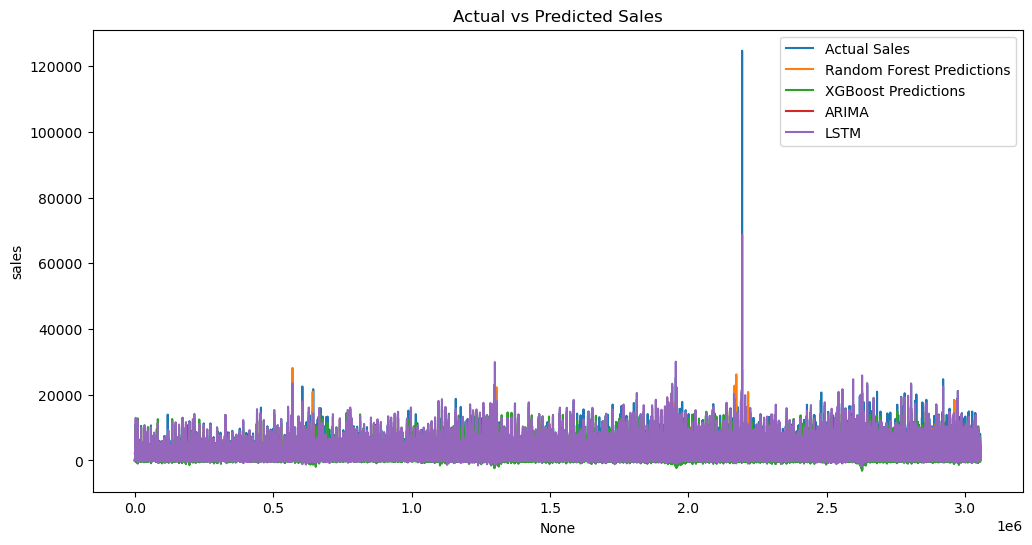

In [79]:
# Visualization
plt.figure(figsize=(12, 6))
sns.lineplot(x=y_test.index, y=y_test, label='Actual Sales')
sns.lineplot(x=y_test.index, y=rf_preds, label='Random Forest Predictions')
sns.lineplot(x=y_test.index, y=xgb_preds, label='XGBoost Predictions')
sns.lineplot(x=y_test.index, y=arima_preds, label='ARIMA')
sns.lineplot(x=y_test.index, y=lstm_predictions, label='LSTM')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.show()

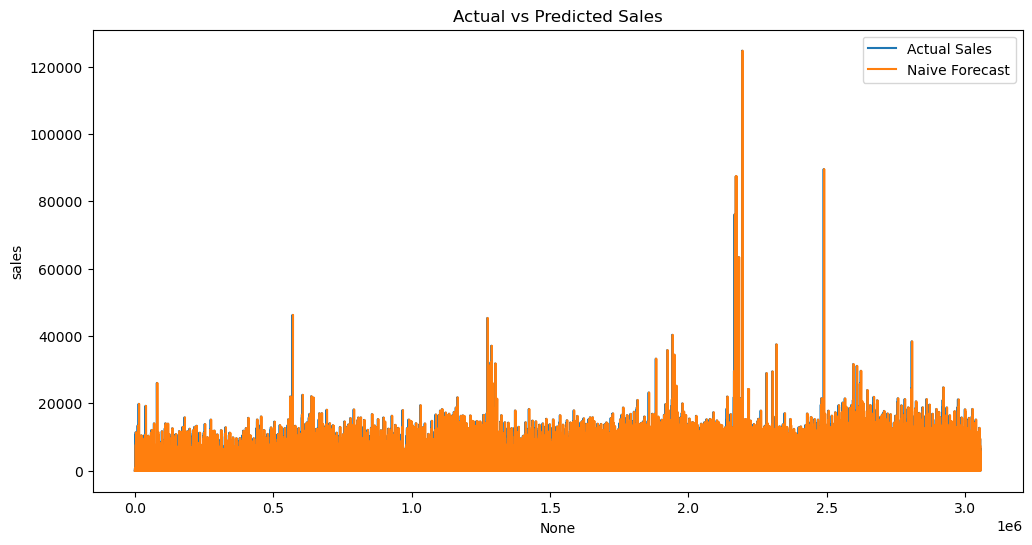

In [80]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=train.index, y=train['sales'], label='Actual Sales')
sns.lineplot(x=train.index, y=train['naive_forecast'], label='Naive Forecast')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.show()

#### Feature Importance using Random Forest

In [ ]:
#feature selection
from sklearn.ensemble import RandomForestRegressor
def random_forest_feature_importance(x_train, y_train):
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(x_train, y_train)
    
    importances = rf_model.feature_importances_
    feature_names = x_train.columns
    
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # percentage importance
    feature_importance_df['Importance Percentage'] = feature_importance_df['Importance'] * 100
    
    # visualization
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance Percentage', y='Feature', data=feature_importance_df)
    plt.title('Random Forest Feature Importance')
    plt.xlabel('Importance (%)')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df

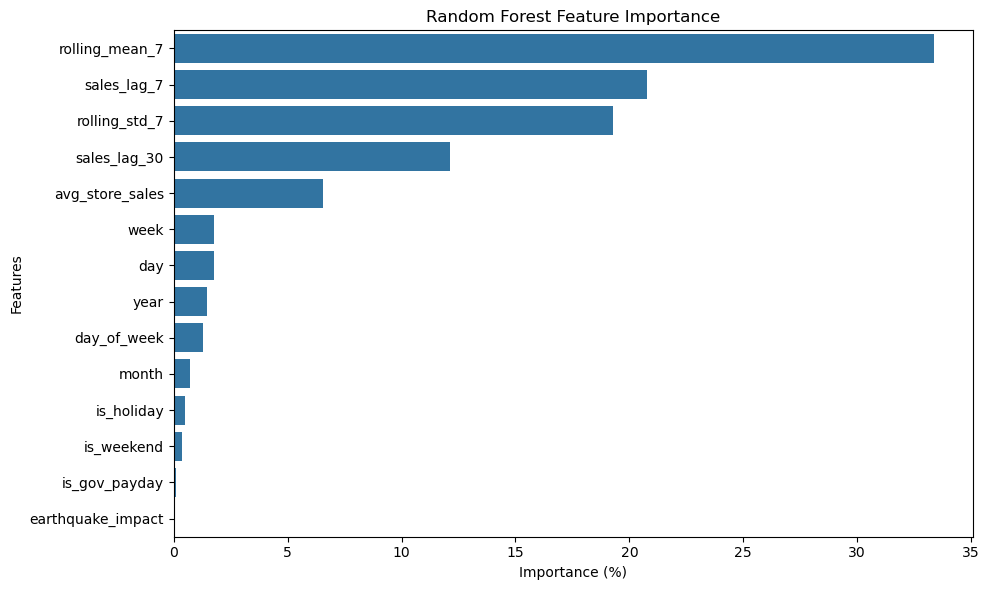

,Feature,Importance,Importance Percentage
11,rolling_mean_7,0.333936,33.393559
9,sales_lag_7,0.207584,20.758442
12,rolling_std_7,0.192714,19.271438
10,sales_lag_30,0.121375,12.137482
13,avg_store_sales,0.065290,6.529002
1,week,0.017782,1.778225
0,day,0.017706,1.770566
3,year,0.014528,1.452779
4,day_of_week,0.012910,1.291046
2,month,0.006980,0.697977


In [90]:
random_forest_feature_importance(X_sample,y_sample)

### Interpretation and Business Insights

In [81]:
result_table

,Model,R2 Score,Root Mean Square Error (RMSE),Mean Absolute Percentage Error (MAPE)
0,ARIMA,-2.550585,2099.175199,3.010674e+18
1,Random Forest Regressor,0.658421,651.094873,1.636273e+17
2,XGBoost,0.737822,570.422436,1.763444e+17
3,Naive Forecast,0.842456,439.501165,7.912285e+15
4,LSTM,0.674795,635.297401,2.131981e+17


1. #### Excluding the base model (Naive Forecast), XGBoost is the best model as the performance metrice for that is the best (Lowest RMSE: 570.422436	, Highest R2: 0.737822, and Lower MAPE:1.763444e+17) in comparison to other ML/DL models.
2. #### Holidays and oil price do not affect sales, but we see an increase in sales due to promotions and the occurence of certain events (Earthquakes).
3. #### Business Recommendations:
    1. ##### Inventory Planning: Use sales forecasts to optimize inventory levels, especially during peak holiday seasons.
    2. ##### Targeted Promotions: Align promotional campaigns with periods of low predicted sales to boost revenue.  